In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

This project is designed to be read starting at the "Summary" section. In case the user wants to do their own analysis, the code for importing the data used is directly below. The code for generating the figures in the introduction is found near the end of the document.

### Importing data and basic feature engineering

In [11]:
# Load relevant dataframes, perform basic processing on crime_df_agency to group it by county
crime_df_agency = pd.read_pickle('crime_data/crime_df_agency.pkl')
crime_df = crime_df_agency.groupby(['county_name', 'year'], as_index = False).sum(numeric_only = True)
crime_df = crime_df.rename(columns = {'county_name': 'county'})

# Dataframe containing statewide and national estimates for crimes
USAandCO_df = pd.read_pickle('USAandCO_df.pkl')

# Dataframe containing economic and population data
econ_df = pd.read_pickle('econ_pop_data/econ_df.pkl')

# Merge crime and economic data
main_df = crime_df.merge(econ_df, on = ['county', 'year'], how = 'outer')

# Obtain state sums by manually summing county/agency data.  Contains some nonsense values (e.g. when poverty rate is summed)
# Just used for plotting
statesums = main_df.groupby('year', as_index = False).sum(numeric_only = True)

In [12]:
### Basic feature engineering.  Calculate rates, avg. values, etc.

#calculate mvt rate in main_df
scaling = 1  # make it easier to change to e.g. 'rate per 1000 people'
main_df['mvt rate'] = (main_df['mvt offense count'] / main_df['population']) * scaling

# Calculate rate for crimes in state / national estimate df. Column labeled with original title + ' rate'
cols_to_convert = ['violent_crime', 'homicide', 'robbery', 'aggravated_assault', 
                'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft', 'arson']

for column in cols_to_convert:
    new_name = column + ' rate'
    USAandCO_df.loc[:, new_name] = USAandCO_df[column].div(USAandCO_df['population'])

In [13]:
statesums['mvt avg value'] = statesums['mvt stolen value total'] / statesums['mvt offense count']
statesums['burglary avg value'] = statesums['burglary value total'] / statesums['burglary offense count']
statesums['robbery avg value'] = statesums['robbery value total'] / statesums['robbery offense count']
statesums['larceny avg value'] = statesums['larceny value total'] / statesums['larceny offense count']

statesums['mvt clearance rate'] = statesums['mvt cleared'] / statesums['mvt offense count']
statesums['homicide clearance rate'] = statesums['homicide cleared'] / statesums['homicide actual']
statesums['aggravated-assault clearance rate'] = statesums['aggravated-assault cleared'] / statesums['aggravated-assault actual']
statesums['arson clearance rate'] = statesums['arson cleared'] / statesums['arson actual']

## Summary

Colorado has experienced a dramatic increase in the rate of motor vehicle thefts over the past decade, surpassing the national average by more than double. The problem is only getting worse, with some predicting that Colorado is on track to have more than $1 billion worth of vehicles stolen annually. Interestingly, this spike appears to be relatively decoupled from violent crime.

To gain a deeper understanding of this phenomenon, this project aims to explore potential factors associated with the rise in vehicle theft. By analyzing county data from the FBI, the US Census Bureau, the Colorado Department of Revenue, and other relevant sources, this report seeks to investigate the potential correlations between other crime, socioeconomic changes, and patterns in drug use with the surge in motor vehicle theft rates.

First, a linear regression analysis was performed on data from all counties with populations greater than 5,000 for the years 2000 - 2021. Afterwards, to try to isolate factors unique to the recent spike, the same analysis was performed for years 2008 - 2021 and only the 20 counties with the highest amount of MVT. The differences in these results highlighted the problems with comparing data between counties that differ largely in population and policing priorities, as well as across time. However, there appears to be a robust positive correlation with sales of recreational marijuana, as well as robbery arrests. There was a consistent negative correlation with poverty rate (and to a lesser extent, median income), and no correlation with unemployment rate. This suggests that overall  MVT is unlikely to occur in economically depressed areas where valuable vehicles are less common.

Plots of the counties hit hardest by motor vehicle thefts reveal a more nuanced picture. Most of these plots show a rise in most types of crime coinciding with the beginning of the 2014 MVT spike. Most notably, these counties saw the beginning of a dramatic rise in inflation-adjusted median income beginning in 2014, which coincides with the legalization of marijuana in Colorado. While the plots do not show an associated rise in unemployment rate, poverty rate, or an engineered "inequality" parameter, there are clear reasons that these features would not capture large amounts of economic displacement, mostly due to the way the US Census Bureau defines "poverty". 

I conclude that the 2014 MVT spike is driven by the rapid economic and cultural changes initiated by the legalization of marijuana. This hypothesis compares favorably to the most popular explanation: that the surge in MVT was precipitated by a 2014 change in how MVTs were prosecuted based on the value of the stolen vehicle. Analysis shows a marked increase in the value of stolen vehicles since 2014, contrary to the claim that thieves are taking advantage of rules that give lenient punishments towards the theft of cheap cars. There is also no noticeable change in MVT clearance rate during this time. Future analysis should include more detailed information on economic factors and homelessness, as well as explore the idea that the MVT spike is driven by repeat offenders.

## Background

Over the past decade, Colorado has seen an alarming surge of motor vehicle thefts (MVT), propelling the state to claim the [highest MVT rate](https://www.nicb.org/news/news-releases/nicb-report-finds-vehicle-thefts-continue-skyrocket-many-areas-us) in the entire United States. Colorado MVT rates are now significantly greater than twice the national average, and the problem appears to be worsening. Though the FBI has not released state and national estimates since 2020, information from [local sources](https://kdvr.com/news/data/colorado-sees-record-number-of-auto-thefts-in-2022/) paints a dire portrait of the [situation](http://www.rmiia.org/auto/auto_theft/colorado_auto_theft_statistics.asp). Just in 2021, the total value of vehicles stolen within Colorado was estimated to be almost \$400 million. The value of vehicles stolen in 2022 [possibly approaches $850 million](https://commonsenseinstituteco.org/on-the-road-to-1-billion-in-vehicles-stolen-the-data-trends-behind-colorados-motor-vehicle-theft-crisis/).

Along with quantifiable economic impact, with [1 in 54 Colorado households falling victim to MVT in 2022](https://csp.colorado.gov/press-release/auto-theft-is-up-and-its-time-to-protect-yourself), it should be noted that vehicle theft is extremely distruptive to the life of the victims.  I know this first hand, as my car was stolen in late February, 2023. Though the vehicle was recovered a few days later, the interior was trashed and tested positive for methamphetamine, with the decontamination and repair costs leaving the vehicle totaled. In the few days they were in possession of my vehicle, the thief also managed to collect four red light / parking tickets, consistent with claims that increased MVT rates have contributed to making Colorado roads less safe due to a ["drive it like you stole it" mentality](https://www.police1.com/traffic-patrol/articles/colorado-sees-all-time-high-for-auto-theft-up-82-since-2019-h3DdA3uAPmJnbs1Y/).

After my car was stolen and I began researching the issue, I found it interesting that this spike appears to be relatively decoupled from other types of crime, or at very least, violent crime. As can be seen in the two plots below, the spike in Colorado MVT since 2014 is a significant divergence from the national average and predates the COVID-19 pandemic. While violent crime rates are also rising, it is proportionally much smaller, and puts CO at barely above the baseline rate. MVT in CO was also high in the years 2000 - 2005, though at the peak in 2005, the rate was only 34% higher than the USA rate, compared to 113% higher in 2020. It is also worth noting that local data show that CO MVT rate went up an additional 37\% in 2021.

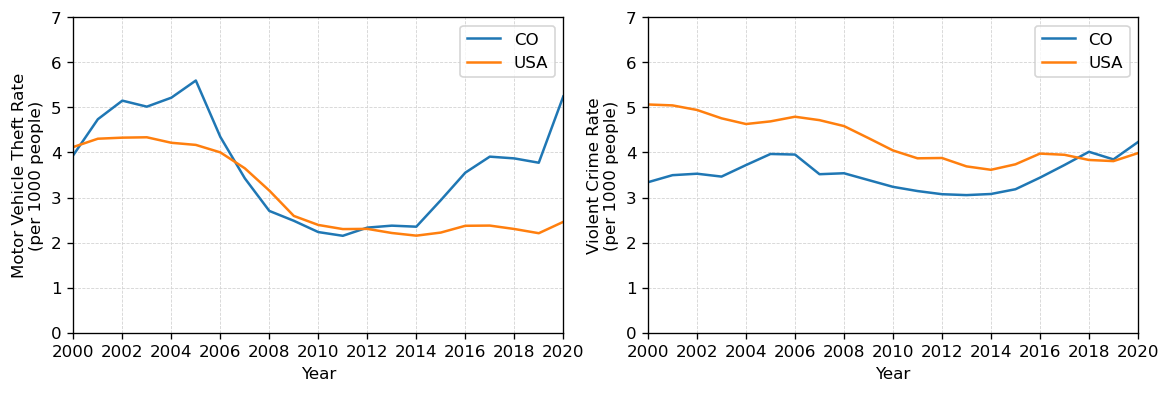

In [14]:
plt.figure(fig1)
plt.show()

Popular explanations for this spike include:
* Legislation in 2014 that [changed the way MVT offenses were prosecuted](https://commonsenseinstituteco.org/on-the-road-to-1-billion-in-vehicles-stolen-the-data-trends-behind-colorados-motor-vehicle-theft-crisis/), with additional changes made during the pandemic
* The rise of [organized car theft](https://www.dea.gov/press-releases/2018/12/12/denver-dea-and-auto-theft-task-force-take-down-black-market-marijuana) rings [operating in CO](https://www.hg.org/legal-articles/the-rise-of-auto-theft-in-denver-26034)
* The legalization and growth of the recreational marijuana industry in 2014 (this one is more popular with fellow CO residents I've talked to)

The precise causes are no doubt complex, and these explanations are not mutually exclusive. However, Colorado has undergone a lot of change during the past decade. What other factors should be considered? [Related to broader socioeconomic explanations](https://lifeoncaphill.com/stories/housing-drug-addiction-prove-to-be-roots-of-motor-vehicle-thefts,403112), I will add: 
* The police officer who recovered my vehicle mentioned many of the car thieves are homeless, and are often living in the vehicles they steal. Could poverty predict MVT rates?
* Many stolen vehicles, including mine, test positive for illegal drugs, [especially methamphetamine](https://www.koat.com/article/almost-90-of-stolen-cars-test-positive-for-methamphetamine/19080589). Is MVT associated with changing drug use habits?
* Though violent crime doesn't appear to be correlated, are any other crimes correlated with MVT?

This project seeks to examine these hypotheses and answer these questions using data from the FBI, the US Census Bureau, and other sources.

## Examining the impact of the 2014 change in legislation

As mentioned above, the most common explanation for the Colorado MVT spike attributes it to changes in how MVT offenses were prosecuted in 2014. The legislative change led to the punishment for MVT being [tied to the value of the stolen vehicle,](https://kdvr.com/news/local/colorado-das-unanimously-support-stronger-car-theft-laws/) with the [theft of a car valued at less than \$2000 only being classified as a misdemeanor.](https://coloradocommunitymedia.com/stories/colorado-auto-theft-bill-penalties-crime-drivers-complex,421746)

Realistically, this project doesn't contain enough data to address this possibility. However, we can look to see if there was any obvious impact on the value of cars stolen or MVT clearance rates. We'll start the analysis with a qualitative look at these features.

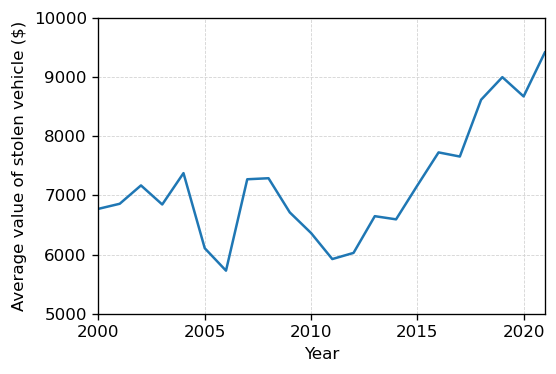

In [15]:
plt.figure(fig_mvtvalue)
plt.show()

The plot above shows the average value of a vehicle stolen in Colorado between the years 2000 and 2021 as calculated from the data obtained from the FBI Crime API. There is a change starting in 2014, but it consists of the average value of a stolen vehicle trending upwards. This is the opposite of what would be expected if the MVT spike was driven by thieves taking advantage of the lighter penalty for stealing cheaper cars.

There is also the chance that lighter penalties for car thefts led to changes in enforcement patterns.  Law enforcement agencies may have started putting less resources into making arrests for MVTs if they believed there was a lower chance of successful prosecution or adequate punishment. The state clearance rates for MVT and various crimes are plotted below.

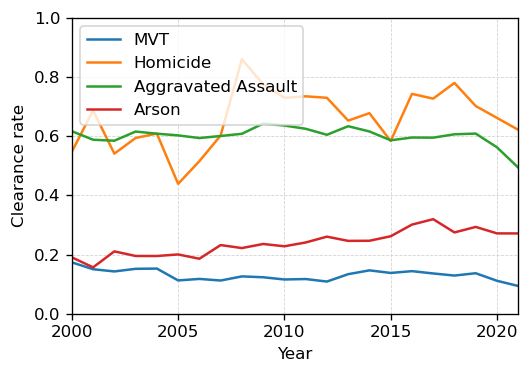

In [16]:
plt.figure(fig_clearance)
plt.show()

There does not appear to be a noticeable change in the clearance rates of MVTs (or homicides, aggravated assaults, and arsons) after 2014, suggesting that the spike was not enabled by police departments being over-saturated or pursuing MVTs less rigorously. This does not disprove that the 2014 legislation change caused the spike, but does show that its impact is not immediately obvious. It is worth noting that there is some evidence that [repeat offenders are driving the MVT spike](https://www.9news.com/article/news/crime/colorado-auto-theft-repeat-offenders/73-0f10520f-f9f4-4997-ac12-a39efc58a23c), and are perhaps enabled by lighter punishments. However, as has been a hot topic of discussion in recent years, the USA already has [an unusually high incarceration rate](https://en.wikipedia.org/wiki/United_States_incarceration_rate). While increasing punishments may be a necessary part of the solution (and is the approach [currently being undertaken](https://coloradosun.com/2023/01/30/colorado-auto-theft-penalties-repeat-offenders/)), it is important to consider other [contributing factors](https://coloradocommunitymedia.com/stories/colorado-auto-theft-bill-penalties-crime-drivers-complex,421746) that could be targeted with non-punitive interventions.

## General Analysis (50 Most Populous Counties, 2000 - 2021)

First, we'll take a look at what a broad analysis tells us, by including data from 2000-2021 and for all counties with average populations greater than 5,000 in Colorado (50 counties total). Since this involves data from the former period of high MVT in CO (2000-2007), anything unique about the recent spike will be washed out to an extent. Also, this analysis is going to look at crime <i>rates</i> rather than raw counts, so there is a possibility that data from sparsely populated counties will be over-represented, even after excluding counties with < 5,000 people.  This is especially notable since the MVT spike is primarily a concern of the Denver metropolitan area. However, it will indicate which features are generally correlated with MVT.

---

The code below creates a new dataframe to be used for fitting, 'analysis_df', which excises columns from 'main_df' that are either not appropriate for analysis, redundant with other columns, or represent crimes that don't seem to be charged often (e.g. 'Human Trafficking', which appears to typically have less than 10 arrests per year statewide).

Number of arrests or reported offenses are converted to rate per person. 

Preliminary modeling showed that the different drug sale arrests categories 'Opium or Cocaine or Their Derivatives', 'Other - Dangerous Nonnarcotic Drugs', 'Synthetic Narcotics', and 'Drug Sale/Manufacturing - Subtotal' had small or nonexistent effects, so they were dropped in favor just including the broader 'Drug Abuse Violations - Grand Total' category for clarity.

In [17]:
# Run this code to see what features are available in the initial dataframe
main_df.columns

Index(['county', 'year', 'mvt stolen value total', 'mvt offense count',
       'mvt cleared', 'burglary value total', 'burglary offense count',
       'robbery value total', 'robbery offense count', 'larceny value total',
       'larceny offense count', 'homicide cleared', 'homicide actual',
       'aggravated-assault cleared', 'aggravated-assault actual',
       'arson cleared', 'arson actual', 'Curfew and Loitering Law Violations',
       'Disorderly Conduct', 'Driving Under the Influence',
       'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement',
       'Forgery and Counterfeiting', 'Fraud', 'Gambling - Total',
       'Human Trafficking - Commercial Sex Acts',
       'Human Trafficking - Involuntary Servitude', 'Larceny - Theft',
       'Liquor Laws', 'Manslaughter by Negligence',
       'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing', 'Susp

In [18]:
analysis_df = main_df[['county', 'year', 'mvt rate', 'population',
       'median_income_2021CPI', 'all poverty rate', 
       'unemployment_rate', 'labor participation rate', 
       'Medical Marijuana Sales', 'Retail Marijuana Sales']].copy()

analysis_df.dropna(subset=['mvt rate'], inplace=True)

# Merge columns that describe similar crimes
analysis_df['DUI and Drunkenness Arrest Rate'] = main_df['Driving Under the Influence'] + main_df['Drunkenness']
analysis_df['DUI and Drunkenness Arrest Rate'] = analysis_df['DUI and Drunkenness Arrest Rate'].div(analysis_df['population'])

analysis_df['Financial Crime Arrest Rate'] = main_df['Forgery and Counterfeiting'] + main_df['Fraud'] + main_df['Embezzlement']
analysis_df['Financial Crime Arrest Rate'] = analysis_df['Financial Crime Arrest Rate'].div(analysis_df['population'])

# Convert others to rate
cols_to_convert = ['burglary offense count', 'robbery offense count', 'larceny offense count',
       'homicide actual', 'aggravated-assault actual', 'arson actual', 
        'Curfew and Loitering Law Violations', 'Disorderly Conduct',
       'Drug Abuse Violations - Grand Total', 'Gambling - Total',
       'Liquor Laws', 'Manslaughter by Negligence',
       'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing',
       'Vagrancy', 'Vandalism', 'Weapons: Carrying, Possessing, Etc.']

for column in cols_to_convert:
    new_name = column + ' rate'
    analysis_df.loc[:, new_name] = main_df[column].div(analysis_df['population'])

I had trouble locating data on homelessness and income inequality broken down by county and year. In theory, more detailed data on income and housing should be available from the [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-1year.html) performed by the US Census Bureau, but I found the API difficult to navigate, and the queries I tried showed a large proportion of missing values. [The Bureau of Labor Statistics](https://www.bls.gov/developers/home.htm) probably also has some valuable info for future reference. 

Though not ideal, I manually created an income 'inequality' parameter with the code below. Both inflation-adjusted 'median income' and 'poverty rate' are normalized to values between 0 and 1 and then multiplied together. There are some problems with this approach, among them being the fact that the US Census Bureau has a coarse [definition of poverty](https://www.census.gov/topics/income-poverty/poverty/guidance/poverty-measures.html) that does not vary with area-dependent cost of living. At very least, this parameter is highest for counties with a high median income and poverty rate, and will hopefully capture any potential effect of wealth (presumably associated with more valuable vehicle ownership) combined with economic desperation in an area.

In [19]:
poverty_scaled = np.array(analysis_df['all poverty rate']).reshape(-1, 1)
medincome_scaled = np.array(analysis_df['median_income_2021CPI']).reshape(-1, 1)

analysis_df['inequality'] = MinMaxScaler().fit_transform(poverty_scaled) \
                          * MinMaxScaler().fit_transform(medincome_scaled)

The correlation matrix for 'analysis_df' is calculated below. Admittedly, the amount of features make the plot hard to interpret, so a list of correlation coefficients for MVT rate are included as well.

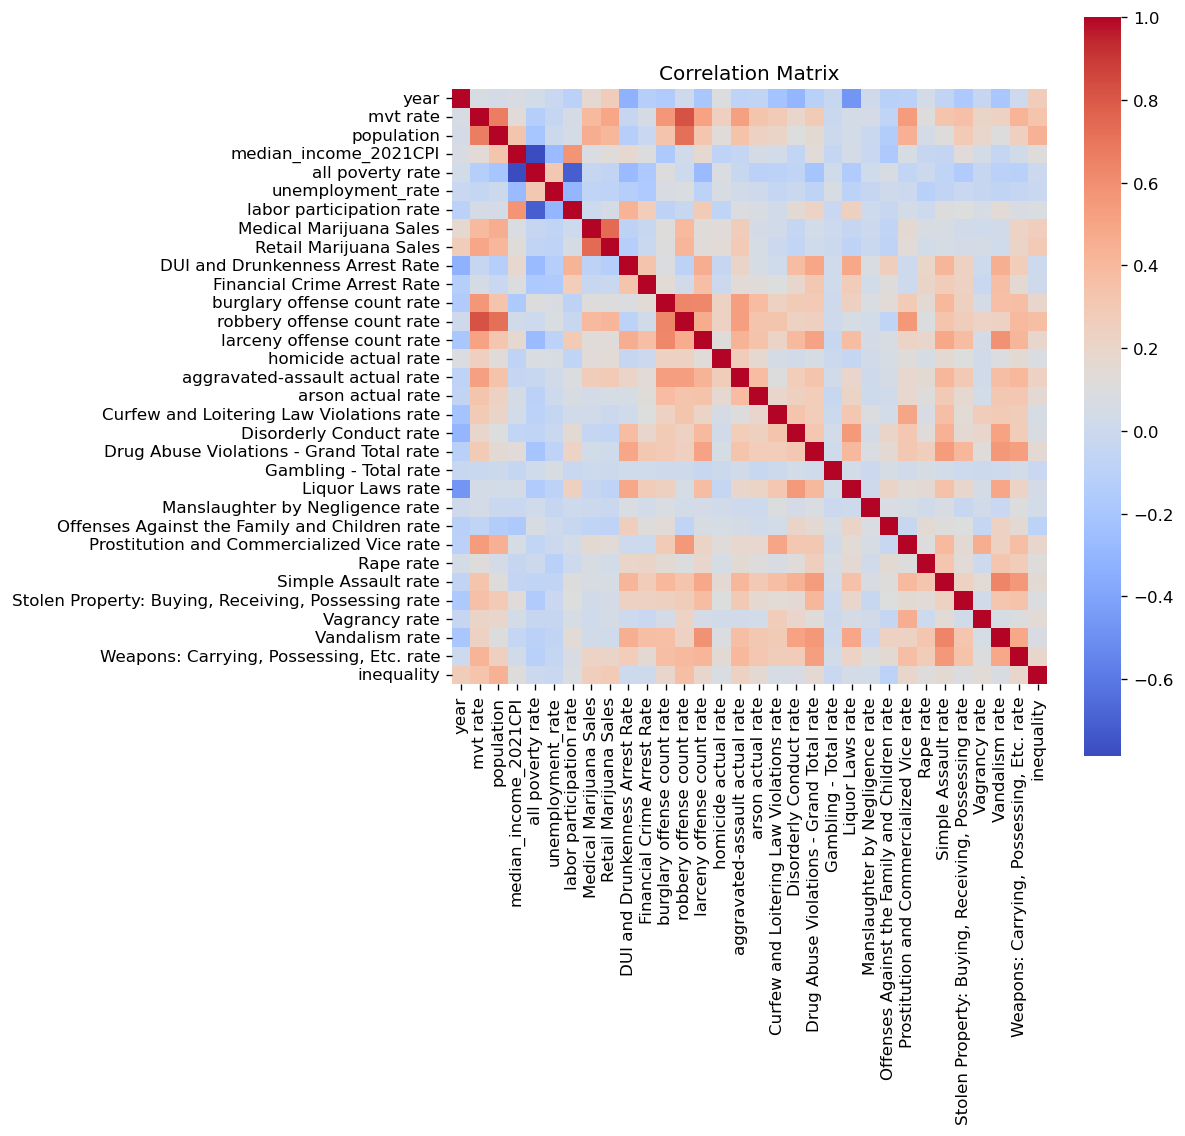

In [20]:
# Compute correlation matrix
#corr_matrix = analysis_df.corr(numeric_only=True)
corr_matrix = analysis_df[analysis_df['population'] > 5000].corr(numeric_only=True)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)

# Set title
plt.title('Correlation Matrix')
plt.show()

In [21]:
corr_matrix['mvt rate'].sort_values(ascending = False)

mvt rate                                               1.000000
robbery offense count rate                             0.821385
population                                             0.671711
burglary offense count rate                            0.565143
Prostitution and Commercialized Vice rate              0.544223
aggravated-assault actual rate                         0.518949
larceny offense count rate                             0.515404
Retail Marijuana Sales                                 0.493173
Weapons: Carrying, Possessing, Etc. rate               0.425745
Medical Marijuana Sales                                0.388398
Stolen Property: Buying, Receiving, Possessing rate    0.355052
inequality                                             0.330994
Simple Assault rate                                    0.330911
arson actual rate                                      0.326313
Curfew and Loitering Law Violations rate               0.285034
Drug Abuse Violations - Grand Total rate

---
Before discussing these results further, let's take a look at the linear regression results and see which correlations are suggested by both analyses.

Unemployment statistics for Broomfield County didn't import correctly, likely because Broomfield just became a county in 2001. Broomfield also has one of the higher MVT rates, so it's important to keep in the analysis. While these stats could likely be tracked down somewhere, the correlation coefficients point towards labor participation rate and unemployment rate both having a nonexistent or negligible correlation with MVT, so it's easiest just to drop them. 

---
<b> Linear Regression </b>

In [22]:
X = analysis_df.drop(['mvt rate', 'county', 'year', 'labor participation rate', 'unemployment_rate'], axis = 1)
X = X[X['population'] > 10000]
#y = analysis_df['mvt rate']
y = analysis_df['mvt rate'][analysis_df['population'] > 10000]


#scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Get the confidence intervals for the parameters
confidence_intervals = results.conf_int()

# Checked if confidence intervals were symmetric
confidence_intervals['avg'] = (confidence_intervals[0] + confidence_intervals[1])/2 
confidence_intervals['params'] = results.params
confidence_intervals.index = ['const'] + X.columns.to_list()
#confidence_intervals*1000
results_df = pd.DataFrame(data = {'parameter': results.params, '+/-': (results.conf_int()[1] - results.params)})
results_df.index = ['const'] + X.columns.to_list() # didn't work to specify within initial df creation for some reason

#calculate R^2 for training and test data
y_test_pred = results.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print("R-squared on training data:", results.rsquared)
print("R-squared on test data:", r2_test)

R-squared on training data: 0.8087276219483976
R-squared on test data: 0.8083257123784274


The table below shows the regression parameters, 95% confidence intervals, and the ratio of the parameter to the uncertainty indicated by the confidence interval. This ratio is calculated based on half the width of the confidence interval; a ratio above 1 suggests a high likelihood that the sign (+/-) of the parameter is correct.

In [23]:
results_df = results_df*1000
results_df['magnitude vs uncertainty'] = abs(results_df['parameter'] / results_df['+/-']) # should it be full width of confidence interval?
results_df.sort_values(by = 'parameter', key = lambda x: x.abs(), ascending = False)

,parameter,+/-,magnitude vs uncertainty
const,1.747369,0.066895,26.121059
robbery offense count rate,0.784672,0.161327,4.863856
Retail Marijuana Sales,0.620379,0.107167,5.788875
larceny offense count rate,0.375042,0.119160,3.147368
all poverty rate,-0.360504,0.163194,2.209057
"Stolen Property: Buying, Receiving, Possessing rate",0.278460,0.079729,3.492592
Prostitution and Commercialized Vice rate,0.233254,0.160682,1.451649
median_income_2021CPI,-0.232269,0.154352,1.504807
population,0.231329,0.134569,1.719039
Medical Marijuana Sales,-0.182592,0.101778,1.794024


Not surprisingly, there's a very high correlation between MVT rate and other varieties of theft, such as robbery, burglary, and larceny. My first thought was that this was due to these offenses being prosecuted as part of the same crime. To check for this, I calculated the overlap explicitly for robbery and MVT (in the 'FBI Crime Data API' notebook also contained in this repo) based on data provided by the FBI on "linked offenses". This calculation indicated that between 2000 and 2021, only 0.07% of MVTs in CO were linked to a robbery, and only 0.3% of robberies were linked to an MVT on average. Browsing the rest of the 'linked offense' data, there doesn't appear to be a strong overlap with MVT and other crimes either, though there is some ambiguity regarding larceny, since it's broken down into numerous subcategories in this dataset.

More interesting is the positive, strong correlation with prostitution. Prostitution, at least to my eye, is in a different category of crime from the "theft" crimes listed above. However, like theft, it's a crime likely undertaken by those in financially desperate circumstances. Notably, crimes like homicide, assault, and drug use, for which there's no obvious financial motive, have essentially no correlation with MVT. 

Conflicting with the claim that MVT and other crimes correlated with it are motivated by financial need, 'Financial Crimes' appear to have a weak but negative correlation. However, I'll point out that this category was assembled from 'Forgery and Counterfeiting', 'Fraud', and 'Embezzlement' arrests, which are stereotypically more "white-collar" crimes.

A further challenge to the hypothesis that economic desperation drives MVT is the lack of a robust positive correlation between MVT rate and any of the economic features, as observed from both the regression and correlation coefficients. In fact, poverty rate appears to have a small but consistent negative correlation with MVT. This makes sense, as an economically depressed area probably doesn't have many valuable cars to steal. The 'inequality' parameter possesses a moderately sized positive correlation coefficient, but a very small negative regression coefficient. However, as mentioned previously, this is a very imperfect measure of economic inequality, mostly due to the fact that poverty rate is not calculated based on the cost of living in an area.

Also notable is the high correlation with recreational marijuana sales, especially since Colorado didn't legalize marijuana until 2014, and the period between 2000-2007 also saw high rates of MVT (though this period was not as high relative to the national rate as the recent spike). Before discussing the results further, the next section will take a qualitative look at the data before an analysis focusing on recent years.

## Distribution of Population and MVT

Before cleaning up the data for a more focused analysis, it's important to discuss the distribution of population and MVT in Colorado.

In [24]:
county_info = main_df[main_df['year'] != 2022]
county_info = county_info.groupby('county').sum()[['mvt offense count', 'population', 'mvt rate']]
county_info.drop('COLORADO', axis=0, inplace=True)
county_info['population avg'] = county_info['population'] / 22
county_info['mvt count avg'] = county_info['mvt offense count'] / 22
county_info['mvt rate avg'] = county_info['mvt rate'] / 22

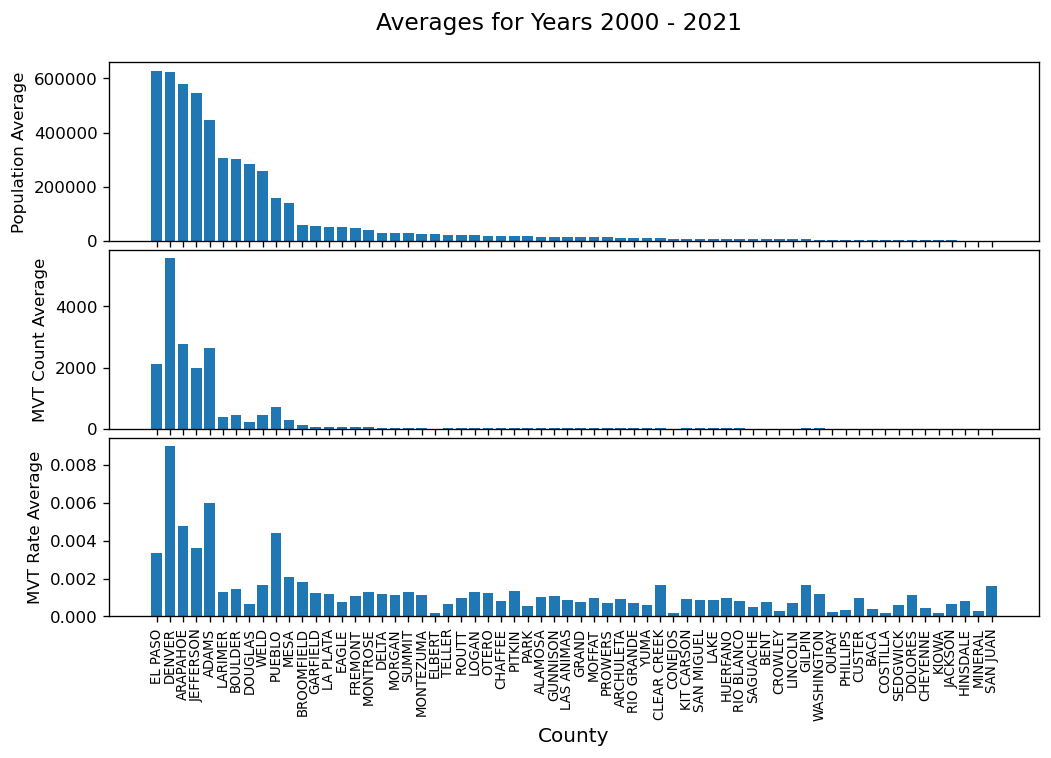

In [25]:
county_info.sort_values(by='population avg', inplace=True, ascending=False)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Plot 1: Population Average by County
axes[0].bar(county_info.index, county_info['population avg'])
axes[0].set_ylabel('Population Average')

# Plot 2: MVT Average by County
axes[1].bar(county_info.index, county_info['mvt count avg'])
axes[1].set_ylabel('MVT Count Average')

# Plot 3: MVT Rate Average by County
axes[2].bar(county_info.index, county_info['mvt rate avg'])
axes[2].set_ylabel('MVT Rate Average')

# Set common x-axis label
plt.xlabel('County', fontsize=12)

# Rotate x-axis tick labels
plt.xticks(rotation=90, fontsize = 8)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.05)

fig.suptitle('Averages for Years 2000 - 2021', fontsize=14, y=0.95)
plt.show()


As can be seen in the plot above, there are 11 counties with more than 100,000 people on average, with the rest of the counties having much smaller populations. There are in fact three counties (San Juan, Mineral, and Hinsdale) with populations less than 1000, meaning that a year with a single MVT in one of these locations could move the rate by 0.001-- comparable to the average MVT rate of many counties. Analysis will be more meaningful if sparsely populated areas are not included.

The plot below displays the top 10 counties for MVT offense counts between 2000 - 2022. The parameters 'lowindex' and 'highindex' can be altered to change the range within the MVT ranking displayed (e.g. values of 20 and 30 will display the counties ranked 21st through 30th for MVT). 

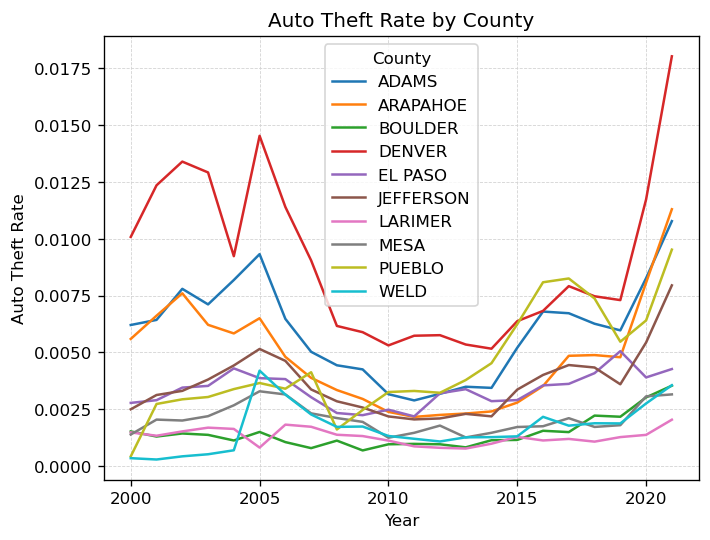

In [26]:
#county_rankings = list(county_info.nlargest(30, 'mvt offense count').index)
county_rankings = list(county_info.sort_values(by= 'mvt offense count', ascending = False).index)
lowindex = 0
highindex = 10

# Only include counties in top 10 for mvt
plot_df = main_df[main_df['county'].isin(county_rankings[lowindex:highindex])]
# Re-arrange data to plot a separate line for each county
plot_df = plot_df.pivot(index='year', columns='county', values='mvt rate')

# Plotting
plot_df.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Auto Theft Rate')
plt.title('Auto Theft Rate by County')
plt.legend(title='County')

plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

Most of the top 20 counties show a similar pattern: MVT rates are high between 2000-2007, and then low until the beginning of the spike in 2014. Outside of the top 20, the data get very noisy and any spike is harder to discern.

Since this project is primarily interested in the factors driving the recent spike (which, unlike the period of high MVT in years before 2008, is significantly higher than the national average), the second analysis will focus on the years 2008 - 2021 and only on the top 20 counties for MVT.

## Spike Analysis (Top 20 Counties, Years 2008 - 2021)

In [27]:
# Adjust indices to change what counties within MVT rankings are included
lowindex = 0
highindex = 20
analysis_df2 = analysis_df[analysis_df['county'].isin(county_rankings[lowindex:highindex])].copy()

lowyear = 2008
highyear = 2050
analysis_df2 = analysis_df2[(analysis_df2['year'] >= lowyear) & (analysis_df2['year'] <= highyear)]

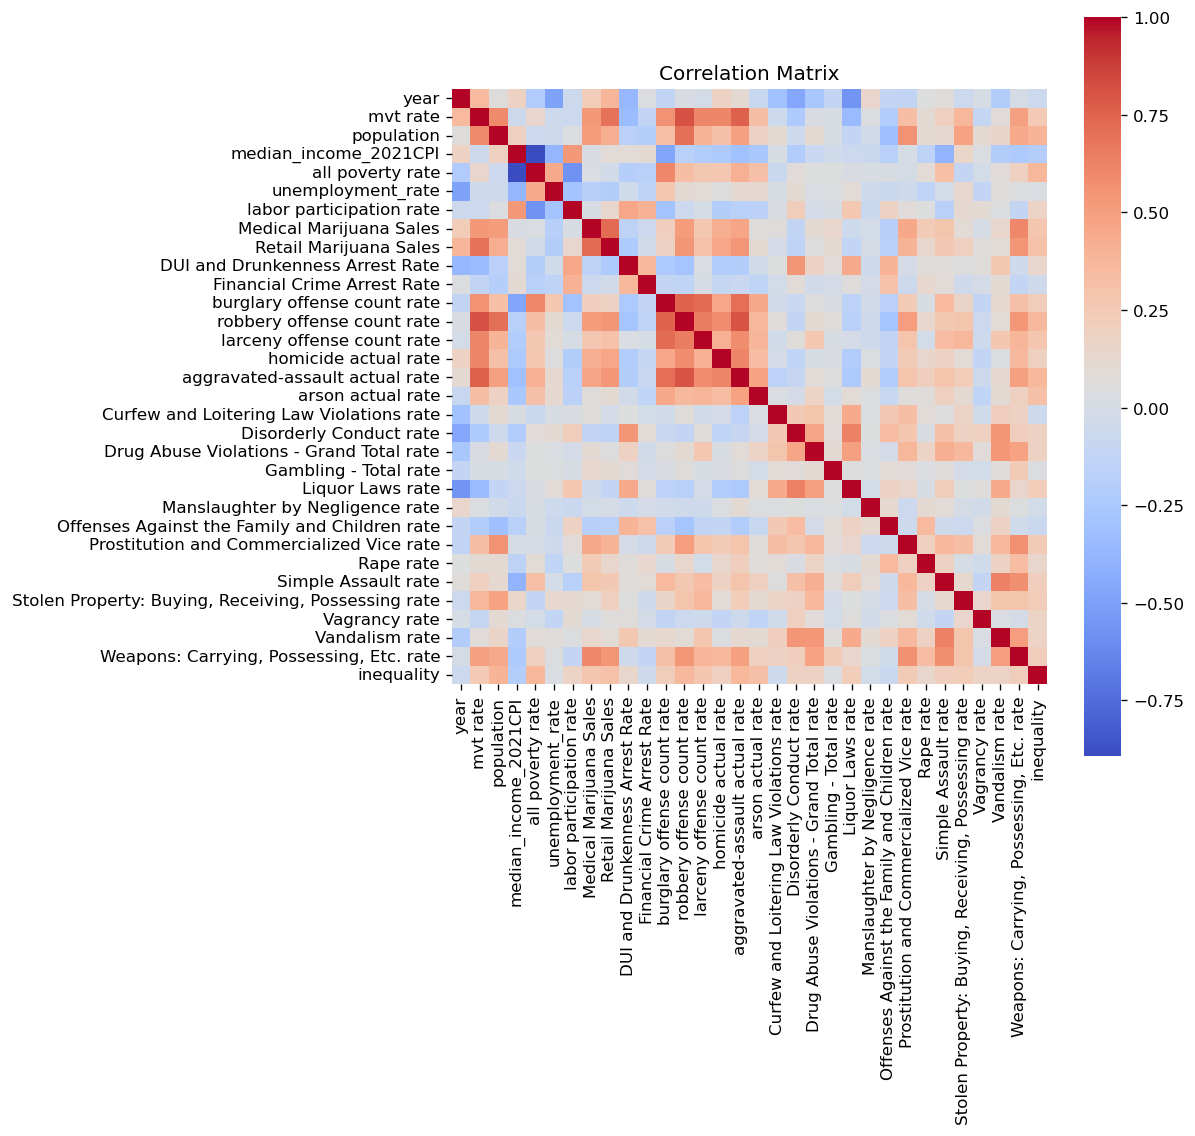

In [28]:
# Compute correlation matrix
corr_matrix2 = analysis_df2.corr(numeric_only=True)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix2, annot=False, cmap='coolwarm', square=True)

# Set title
plt.title('Correlation Matrix')
plt.show()

In [29]:
corr_matrix2['mvt rate'].sort_values(ascending = False)

mvt rate                                               1.000000
robbery offense count rate                             0.809284
aggravated-assault actual rate                         0.760160
Retail Marijuana Sales                                 0.694957
homicide actual rate                                   0.611875
larceny offense count rate                             0.610135
population                                             0.594569
burglary offense count rate                            0.563478
Medical Marijuana Sales                                0.526990
Weapons: Carrying, Possessing, Etc. rate               0.493507
Stolen Property: Buying, Receiving, Possessing rate    0.372493
year                                                   0.352900
Prostitution and Commercialized Vice rate              0.331144
arson actual rate                                      0.330591
inequality                                             0.249916
Simple Assault rate                     

In [30]:
# Also dropping 'larceny' and 'stolen property' features, since they may overlap with MVT
X = analysis_df2.drop(['mvt rate', 'county', 'year', 'labor participation rate',
                       'unemployment_rate', 'Stolen Property: Buying, Receiving, Possessing rate',
                      'larceny offense count rate'], axis = 1)

y = analysis_df2['mvt rate']

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Get the confidence intervals for the parameters
confidence_intervals = results.conf_int()

# Checked if confidence intervals were symmetric
confidence_intervals['avg'] = (confidence_intervals[0] + confidence_intervals[1])/2 
confidence_intervals['params'] = results.params
confidence_intervals.index = ['const'] + X.columns.to_list()
#confidence_intervals*1000
results_df = pd.DataFrame(data = {'parameter': results.params, '+/-': (results.conf_int()[1] - results.params)})
results_df.index = ['const'] + X.columns.to_list()

#calculate R^2 for training and test data
y_test_pred = results.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print("R-squared on training data:", results.rsquared)
print("R-squared on test data:", r2_test)

R-squared on training data: 0.852207349491265
R-squared on test data: 0.8299488277815037


In [31]:
results_df = results_df*1000
results_df['magnitude vs uncertainty'] = abs(results_df['parameter'] / results_df['+/-']) # should it be full width of confidence interval?
results_df.sort_values(by = 'parameter', key = lambda x: x.abs(), ascending = False)

,parameter,+/-,magnitude vs uncertainty
const,2.310591,0.116292,19.868902
robbery offense count rate,1.058628,0.368647,2.871656
Retail Marijuana Sales,0.795807,0.238479,3.337016
all poverty rate,-0.495754,0.393054,1.261287
Liquor Laws rate,-0.485190,0.207114,2.342628
population,0.342294,0.246283,1.389841
Vandalism rate,0.322789,0.204872,1.575569
Prostitution and Commercialized Vice rate,-0.313872,0.176803,1.775266
median_income_2021CPI,-0.276690,0.350691,0.788985
Medical Marijuana Sales,-0.226999,0.204549,1.109754


The most robust findings between the two analyses appear to be the positive correlation with recreational marijuana sales and robbery arrests, and the negative correlation with median income and poverty rate. Interestingly, the correlation with prostitution arrests switched from positive to negative. This makes sense when looking at the state-wide pattern of arrests in prostitution:

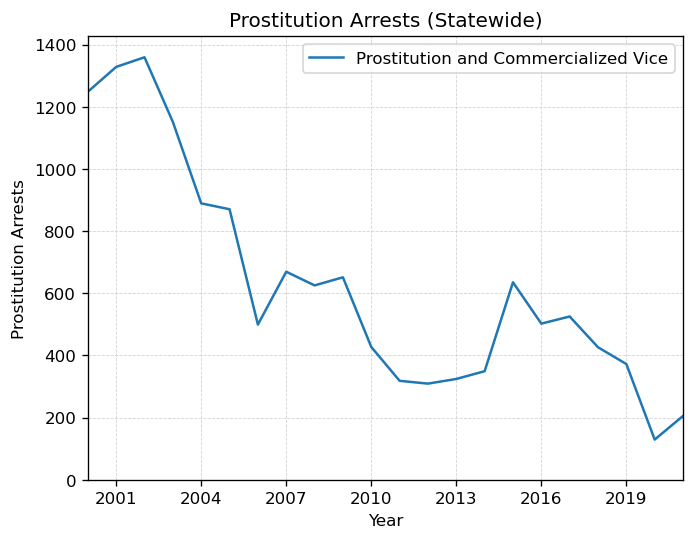

In [32]:
statesums.plot(x = 'year', y = 'Prostitution and Commercialized Vice')
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.title('Prostitution Arrests (Statewide)')
plt.xlabel('Year')
plt.ylabel('Prostitution Arrests')
plt.ylim(ymin = 0)
plt.xlim(2000,2021)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

While there is indeed a spike in 2014 relative to the overall trend, arrests have been going consistently downwards since 2000. The high correlation observed in the initial analysis is only due to the period of high MVT between 2000 - 2007. While this may reflect an overall decrease in prostitution, I think it may actually be due to changing priorities in policing. Several of the other correlations observed in the linear regression analysis could be explained by a difference in "conservative" attitudes over time and in rural vs. urban areas (the latter observing a much higher amount of MVT). I believe this is the best explanation for the negative correlation between MVT and the rates of liquor law, gambling, and vagrancy violations. In addition, it seems possible that this explains the negative correlation with medical marijuana-- in urban areas where marijuana use is more accepted, recreational marijuana sales probably displaced medical marijuana sales to some extent.

## A closer look at the top 5 counties

The code below plots a selected feature from 'main_df' for the five counties with the highest counts of MVT. By default, it displays inflation-adjusted median income. The range of counties displayed can also be adjusted.

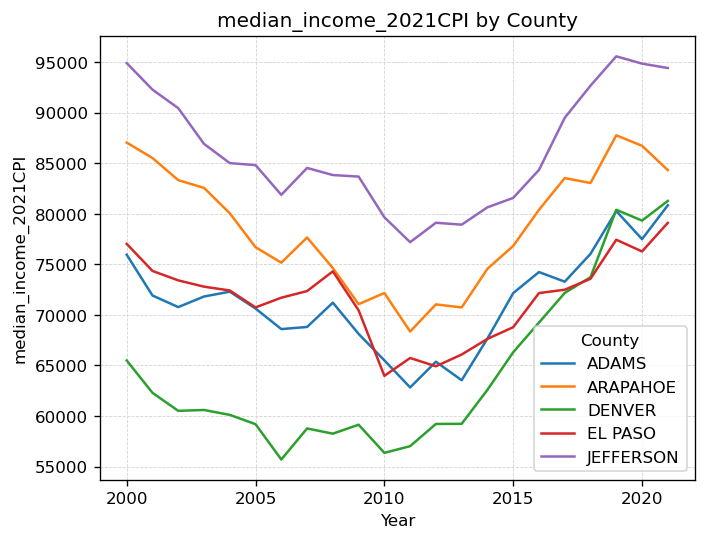

In [33]:
# Choose what to plot (copy/paste into 'feature')
feature = 'median_income_2021CPI'
features = ['population', 'burglary offense count', 'robbery offense count', 'larceny offense count','homicide actual',
       'aggravated-assault actual', 'arson actual', 'Curfew and Loitering Law Violations',
       'Disorderly Conduct', 'Driving Under the Influence',
       'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement',
       'Forgery and Counterfeiting', 'Fraud', 'Gambling - Total', 'Larceny - Theft',
       'Liquor Laws', 'Manslaughter by Negligence', 'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing', 'Suspicion',
       'Vagrancy', 'Vandalism', 'Weapons: Carrying, Possessing, Etc.',
       'Opium or Cocaine or Their Derivatives',
       'Other - Dangerous Nonnarcotic Drugs', 'Synthetic Narcotics',
       'Drug Sale/Manufacturing - Subtotal', 'population',
       'median household income', 'all poverty rate',
       'Medical Marijuana Sales', 'Retail Marijuana Sales',
       'unemployment_rate', 'labor participation rate', 'median_income_2021CPI', 'mvt rate']

#county_rankings = list(county_info.nlargest(30, 'mvt offense count').index)
county_rankings = list(county_info.sort_values(by= 'mvt offense count', ascending = False).index)
lowindex = 0
highindex = 5

# Only include counties in top 10 for mvt
plot_df = main_df[main_df['county'].isin(county_rankings[lowindex:highindex])]
# Re-arrange data to plot a separate line for each county
plot_df = plot_df.pivot(index='year', columns='county', values=feature)

# Plotting
plot_df.plot(kind='line')
plt.xlabel('Year')
plt.ylabel(feature)
plt.title(feature +' by County')
plt.legend(title='County')

plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

Some observations:
* Denver (by far the leader in MVT) has some unique trends
  * A clear spike in homicide beginning in 2014. Probably only apparent in Denver because homicide is so rare overall.
  * Weapon carrying charges showed a dramatic climb beginning around 2014.
  * There was also a temporary bump in curfew and loitering violations in 2014, which slowly declines. The "conservative" effect seems to be at play here, since this type of arrest was <i>much</i> higher before 2005.
* Many other crimes (e.g. aggravated assault) also seem to go up in 2014 in a way that's not clear in the broader analysis.
* Opium/cocaine distribution arrests are noticeably higher in the period 2012 - 2019. This applies to most of the drug arrest categories, but is particularly noticeable here.
* Poverty and unemployment rate are actually highest during 2008 - 2013, the period of lower MVT.

All this is to point out that the Denver metropolitan area (which includes all top 5 counties except for El Paso) has undergone changes that aren't apparent from looking at statewide data. 

What I believe is most important is the change in inflation-adjusted median income. Overall, median income follows a similar u-shaped pattern to MVT rate. More significant is that median income remains relatively flat in Denver, and then has a clear surge starting in 2014, associated with the legalization of marijuana. I'll discuss this more in the following section.

## Conclusions: The Effects of Marijuana Legalization Lead to the MVT Spike

The distribution of population and MVT within Colorado (both of which are concentrated around Denver) make a statewide analysis of the factors driving MVT difficult. However, I believe there are three conclusions to be drawn from the correlation coefficients and linear regression parameters:
* Statewide and in the years 2000-2021, MVT is not strongly correlated with other crime, other than other varieties of theft (mostly robbery). This includes drug abuse violations, which is surprising, as so many vehicles are [recovered contaminated with methamphetamine](https://www.koat.com/article/almost-90-of-stolen-cars-test-positive-for-methamphetamine/19080589)
* MVT does not occur as often in poor areas, likely because there are not as many valuable vehicles to steal. These areas are also probably less populated, so car theft would be more recognizable. ("Hey, that guy's driving Bob's car!")
* Most importantly, marijuana sales are strongly correlated, even in the broadest analysis that included many years before marijuana was legalized.

Examining the counties where most MVTs are occuring, especially Denver, it is apparent that 2014 brought on a lot of change, and  that the MVT spike is not as isolated as it appears when examining the statewide data. In fact, most crimes seem to have started going up during the same period. Most likely, these changes were brought on by the legalization of marijuana in 2014 and the growth of the associated industry. While median income was a negative factor for MVT in the statewide analysis, there is a clear correlation between an increase in median income over time and MVT in the counties where MVT is most prevalent. 

The legalization of marijuana and associated economic changes also likely caused:
* A rise in cost of living, and people getting "priced out" of areas like Denver. This would not be captured by poverty rates, as the thresholds are not geographically adjusted. As mentioned in the introduction to this project, it seems many car thieves are living in the cars they steal.
* An influx of people moving to Denver specifically because of their interest in marijuana. This is not to suggest that all (or even an appreciable amount) of marijuana users are car thieves, but there's probably a larger overlap between crime and enthusiastic marijuana use than with skiing, rock climbing, or working in aerospace engineering.
* Displacement of organized crime organizations formerly involved in marijuana manufacture and sale. This may be important, as some speculate the MVT spike is driven by [organized car theft rings](https://www.denverpost.com/2022/05/19/denver-colorado-car-theft-indictment/).

All of these factors could lead to increased crime. While not as isolated as it first appears, the increase in MVT was most dramatic. Compared to violent crime, there is a more obvious financial incentive, so a closer look at economic factors like homelessness and would be worthwhile in future analysis.

---

<b> A quick comparison to other states that legalized weed </b>

While this could be a project in itself, we'll just take a look at the first five states to legalize recreational marijuana sales and see if there was an associated spike. (info taken from Wikipedia)

| Jurisdiction         | Licensed sales since |
|----------------------|----------------------|
| Colorado             | 01/01/14             |
| Washington (state)   | 07/08/14             |
| Oregon               | 10/01/15             |
| Alaska               | 10/29/16             |
| Nevada               | 07/01/17             |



(0.0, 600.0)

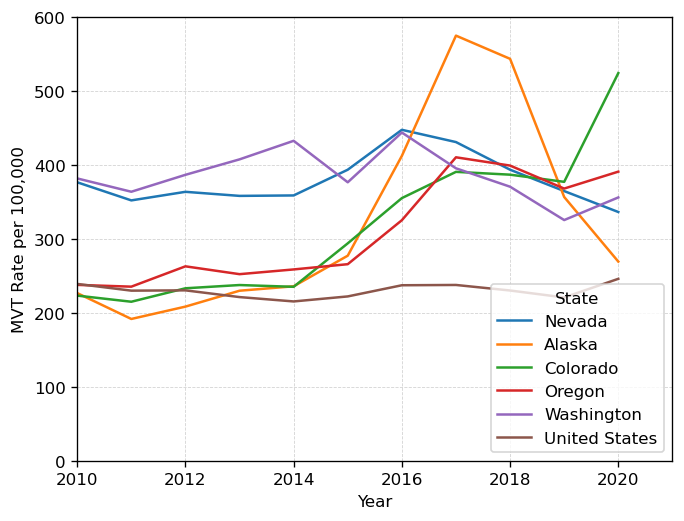

In [34]:
staterates = pd.read_csv('state rates/combined.csv', index_col= 0).T
staterates.index = staterates.index.astype(int)
staterates.plot()
plt.xlabel('Year')
plt.ylabel('MVT Rate per 100,000')
plt.legend(title='State')
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.xlim(2010, 2021)
plt.ylim(0, 600)

Colorado, Alaska, and Oregon all show spikes associated with the year recreational marijuana sales were legalized. Alaska's spike seems to predate legalization slightly compared to the other two states, but the association seems strong. Washington and Nebraska do not show an MVT spike. To speculate, Washington may have not been as impacted since it had a larger economy before legalization, and Nevada may have not been as strongly affected since it was the last state of the five to legalize. It also seems that these two states had a higher baseline rate of thefts.

While not conclusive, this analysis does suggest that early legalization of recreational marijuana sales led to changes (likely economic and cultural) associated with a rise in motor vehicle theft. This is not to say that legalization was a mistake. After the initial surge, Alaska's MVT rate went back to baseline, and it seems like Colorado and Oregon may have started the same process before the start of the 2020 COVID-19 pandemic and the societal changes it brought on. Perhaps some growing pains are inevitable. One would also think that some changes, such as encouraging an influx of marijuana enthusiasts to move to a state, are only going to occur for the first few states to legalize.

While this project did not uncover any general factors contributing to motor vehicle theft, I believe a strong case was made for the impact of marijuana legalization. To reiterate, this is unlikely because of anything inherent to marijuana use, but rather the rapid economic changes brought on by the birth of a new (legal) industry. I also believe this case is much stronger than the competing theory of the change being due to the 2014 change in legislation, though the latter was not ruled out. Future analysis should include more detailed information on homelessness and economic inequality / desperation, as well as attempt to determine the role of repeat offenders in rising rates of MVT.

## Code for generating figures

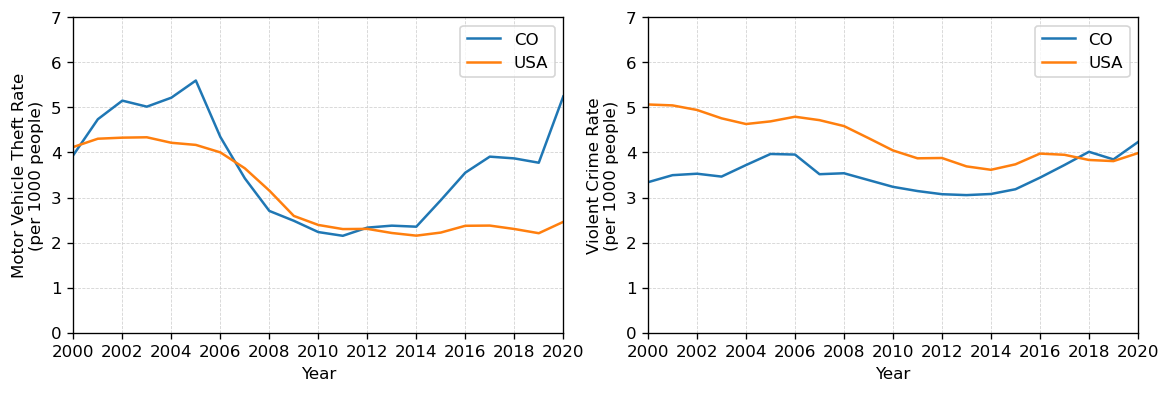

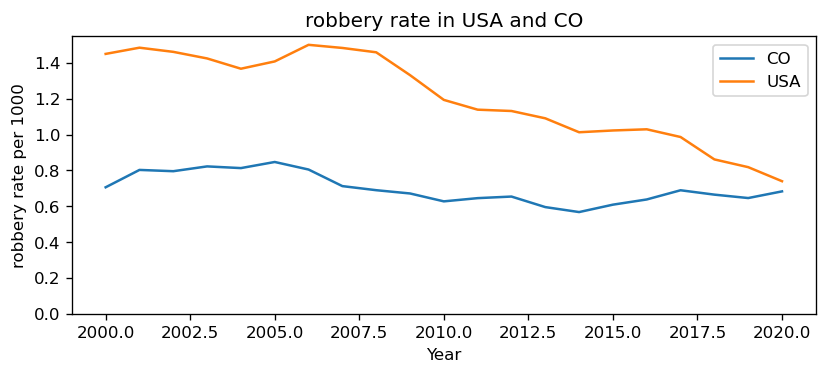

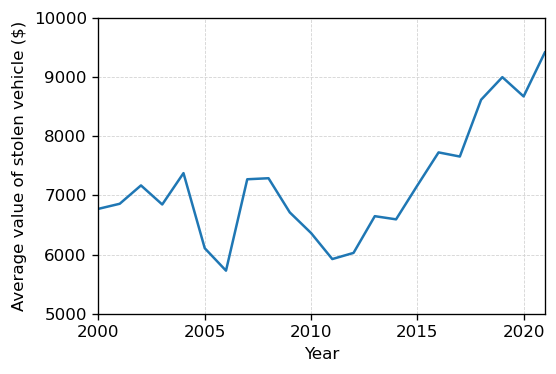

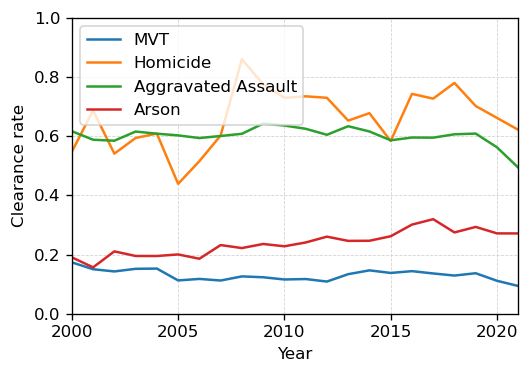

In [35]:
### Code for generating figures

## Figure 1 - MVT and violent crime rates in CO and USA
plt.rcParams['figure.dpi'] = 120
scaling = 1000 
figscale = 0.8
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (12*figscale,4*figscale))
fig1.tight_layout(w_pad = 2)

#create subplots
for key, grp in USAandCO_df.groupby('state_abbr'):
    grp['motor_vehicle_theft rate'] = grp['motor_vehicle_theft rate']*scaling
    grp['violent_crime rate'] = grp['violent_crime rate']*scaling
    grp.plot(ax = ax1, kind='line', x = 'year', y = 'motor_vehicle_theft rate', label = key)
    grp.plot(ax = ax2, kind='line', x = 'year', y = 'violent_crime rate', label = key)

# Configure subplot 1    
ax1.legend(loc = 'best')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax1.set_xlabel('Year')
ax1.set_xlim(2000, 2020)
ax1.set_ylabel('Motor Vehicle Theft Rate\n(per 1000 people)')
ax1.set_ylim(0, 7)


# Configure subplot 2 
ax2.legend(loc = 'best')
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax2.set_xlabel('Year')
ax2.set_xlim(2000, 2020)
ax2.set_ylabel('Violent Crime Rate\n(per 1000 people)')
ax2.set_ylim(0, 7)

ax1.grid(color='lightgray', linestyle='--', linewidth=0.5)
ax2.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Set plot parameters
plt.rcParams['figure.dpi'] = 120
scaling = 1000

# Filter numeric columns
plotting_columns = ['violent_crime rate',
       'homicide rate', 'robbery rate', 'aggravated_assault rate',
       'property_crime rate', 'burglary rate', 'larceny rate',
       'motor_vehicle_theft rate', 'arson rate']

# Create the plot
fig2, ax3 = plt.subplots(figsize=(8, 3))
plot_line, = ax3.plot([], [], label='')

# Function to update the plot based on the selected column
def update_plot(column):
    ax3.clear()  # Clear the previous plot
    for key, grp in USAandCO_df.groupby('state_abbr'):
        grp[column] = grp[column] * scaling
        grp.plot(ax=ax3, kind='line', x='year', y=column, label=key)
    ax3.legend()
    ax3.set_xlabel('Year')
    ax3.set_ylabel(column+' per ' + str(scaling))
    ax3.set_title(f'{column} in USA and CO')
    ax3.set_ylim(ymin=0)
    plt.draw()
    plt.show()  # Add this line to display the updated plot

# Select the column based on the specified index
index = 2  
column = plotting_columns[index]

# Initial plot based on the selected column
update_plot(column)

plt.show()

# Plot of average value of stolen vehicles in Denver
fig_mvtvalue, ax_mvtvalue = plt.subplots(figsize = (4.8,3.2))
statesums.loc[:, ['year', 'mvt avg value']].plot(ax = ax_mvtvalue, x = 'year')

ax_mvtvalue.legend().remove()
ax_mvtvalue.set_xlabel('Year')
ax_mvtvalue.set_xlim(2000, 2021)
ax_mvtvalue.set_ylabel('Average value of stolen vehicle ($)')
ax_mvtvalue.set_ylim(5000, 10000)

ax_mvtvalue.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax_mvtvalue.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

ax_mvtvalue.grid(color='lightgray', linestyle='--', linewidth=0.5)

## Plot of clearance rates
fig_clearance, ax_clearance = plt.subplots(figsize=(4.8, 3.2))
statesums[['year', 'mvt clearance rate', 'homicide clearance rate', 'aggravated-assault clearance rate', 'arson clearance rate']] \
    .plot(ax=ax_clearance, x='year')

ax_clearance.set_xlabel('Year')
ax_clearance.set_xlim(2000, 2021)
ax_clearance.set_ylabel('Clearance rate')
ax_clearance.set_ylim(0, 1)

ax_clearance.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax_clearance.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

mylabels = ['MVT', 'Homicide', 'Aggravated Assault', 'Arson']
ax_clearance.grid(color='lightgray', linestyle='--', linewidth=0.5)
ax_clearance.legend(loc = 'best', labels = mylabels)



## Scratchpad

In [36]:
analysis_df.columns

Index(['county', 'year', 'mvt rate', 'population', 'median_income_2021CPI',
       'all poverty rate', 'unemployment_rate', 'labor participation rate',
       'Medical Marijuana Sales', 'Retail Marijuana Sales',
       'DUI and Drunkenness Arrest Rate', 'Financial Crime Arrest Rate',
       'burglary offense count rate', 'robbery offense count rate',
       'larceny offense count rate', 'homicide actual rate',
       'aggravated-assault actual rate', 'arson actual rate',
       'Curfew and Loitering Law Violations rate', 'Disorderly Conduct rate',
       'Drug Abuse Violations - Grand Total rate', 'Gambling - Total rate',
       'Liquor Laws rate', 'Manslaughter by Negligence rate',
       'Offenses Against the Family and Children rate',
       'Prostitution and Commercialized Vice rate', 'Rape rate',
       'Simple Assault rate',
       'Stolen Property: Buying, Receiving, Possessing rate', 'Vagrancy rate',
       'Vandalism rate', 'Weapons: Carrying, Possessing, Etc. rate',
       'i

(0.0, 0.011618994798647288)

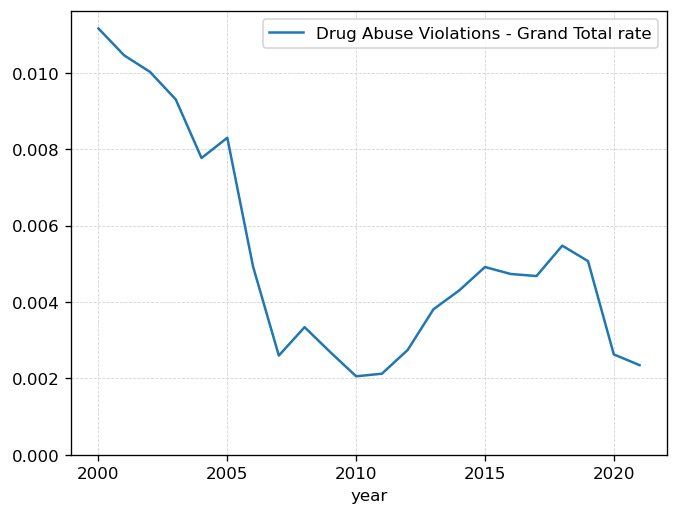

In [37]:
countyindex = 0
top10counties = ['DENVER', 'ARAPAHOE', 'ADAMS', 'EL PASO', 'JEFFERSON', 'PUEBLO', 'WELD', 'BOULDER', 'LARIMER', 'MESA']

feature = 'Drug Abuse Violations - Grand Total rate'
features = ['population', 'median_income_2021CPI',
       'all poverty rate', 'unemployment_rate', 'labor participation rate',
       'Medical Marijuana Sales', 'Retail Marijuana Sales',
       'DUI and Drunkenness Arrest Rate', 'Financial Crime Arrest Rate',
       'burglary offense count rate', 'robbery offense count rate',
       'larceny offense count rate', 'homicide actual rate',
       'aggravated-assault actual rate', 'arson actual rate',
       'Curfew and Loitering Law Violations rate', 'Disorderly Conduct rate',
       'Drug Abuse Violations - Grand Total rate', 'Gambling - Total rate',
       'Liquor Laws rate',
       'Offenses Against the Family and Children rate',
       'Prostitution and Commercialized Vice rate', 'Rape rate',
       'Simple Assault rate',
       'Stolen Property: Buying, Receiving, Possessing rate', 'Vagrancy rate',
       'Vandalism rate', 'Weapons: Carrying, Possessing, Etc. rate', 'inequality']

analysis_df[analysis_df['county'] == top10counties[countyindex]].plot(x = 'year', y = feature)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.ylim(ymin = 0)

In [38]:
statesums.columns

Index(['year', 'mvt stolen value total', 'mvt offense count', 'mvt cleared',
       'burglary value total', 'burglary offense count', 'robbery value total',
       'robbery offense count', 'larceny value total', 'larceny offense count',
       'homicide cleared', 'homicide actual', 'aggravated-assault cleared',
       'aggravated-assault actual', 'arson cleared', 'arson actual',
       'Curfew and Loitering Law Violations', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drug Abuse Violations - Grand Total',
       'Drunkenness', 'Embezzlement', 'Forgery and Counterfeiting', 'Fraud',
       'Gambling - Total', 'Human Trafficking - Commercial Sex Acts',
       'Human Trafficking - Involuntary Servitude', 'Larceny - Theft',
       'Liquor Laws', 'Manslaughter by Negligence',
       'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing', 'Suspicion',
       'V

<Axes: xlabel='year'>

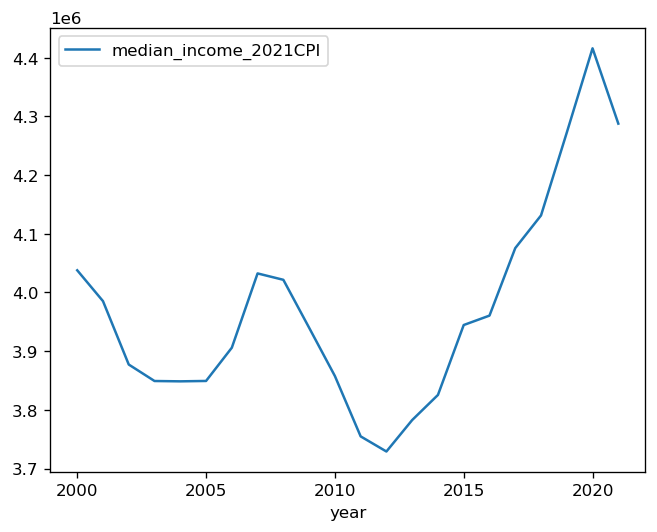

In [39]:
statesums[statesums['year'] != 2022].plot(x = 'year', y = 'median_income_2021CPI')

<Axes: xlabel='year'>

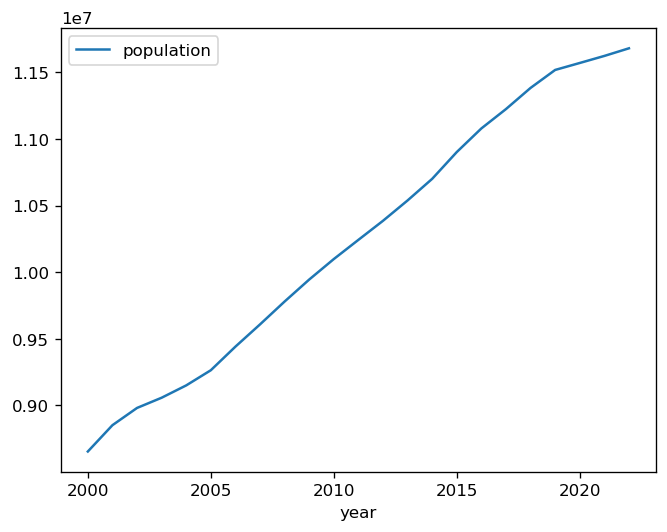

In [40]:
statesums.plot(x = 'year', y = 'population')

### scikit learn

In [41]:
X = analysis_df.drop(['mvt rate', 'county', 'year'], axis = 1)
y = analysis_df['mvt rate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

regressor = LinearRegression()

regressor.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
r2_train = regressor.score(X_train, y_train)
r2_test = regressor.score(X_test, y_test)
print("R-squared on training data:", r2_train)
print("R-squared on test data:", r2_test)

In [ ]:
feature_names = X.columns.tolist()

coefficients = regressor.coef_ * 1000

# Create a dictionary mapping feature names to their importance
feature_importance = dict(zip(feature_names, coefficients))

# Sort the feature importance dictionary by values in descending order
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

# Print the feature importance
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")